# Use of GMMs to Model Zero-Dispersion Optical Channel

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Using Gaussian Mixture Models (GMMs) to approximate the PDF of the channel output and the conditional PDFs of a (complex) transmission channel

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
import ipywidgets as widgets
from sklearn import mixture


Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
\tilde{t}_{k+1} = \tilde{t}_k\exp\left(\jmath\frac{L}{K}\gamma|\tilde{t}_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $\tilde{t}_0=t$ is the channel input (the modulated, complex symbols) and $r=\tilde{t}_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel. Usually $K=50$ gives a good approximation.

Here, we specify a 16-QAM to communicate over the channel.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," _Proc. European Conference on Optical Communications (ECOC)_, Rome, Sep. 2018

In [11]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 10 # number of steps used in the channel model


constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6])}

def simulate_channel(x, Pin, constellation):      
    # modulate 16-qam
    assert all(x >= 0)
    assert all(x < len(constellation))
    # input power (in W), normalize to input power
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2)/input_power_linear)
    modulated = constellation[x] * norm_factor

    # noise variance per step    
    sigma = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    

    # channel model
    temp = np.array(modulated, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        
        temp = temp * np.exp(1j*rotcoff) + sigma*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return temp

We consider 16-QAM transmission over this channel.

Show constellation as a function of the fiber input power. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input Power Pin (dBm)', lay…

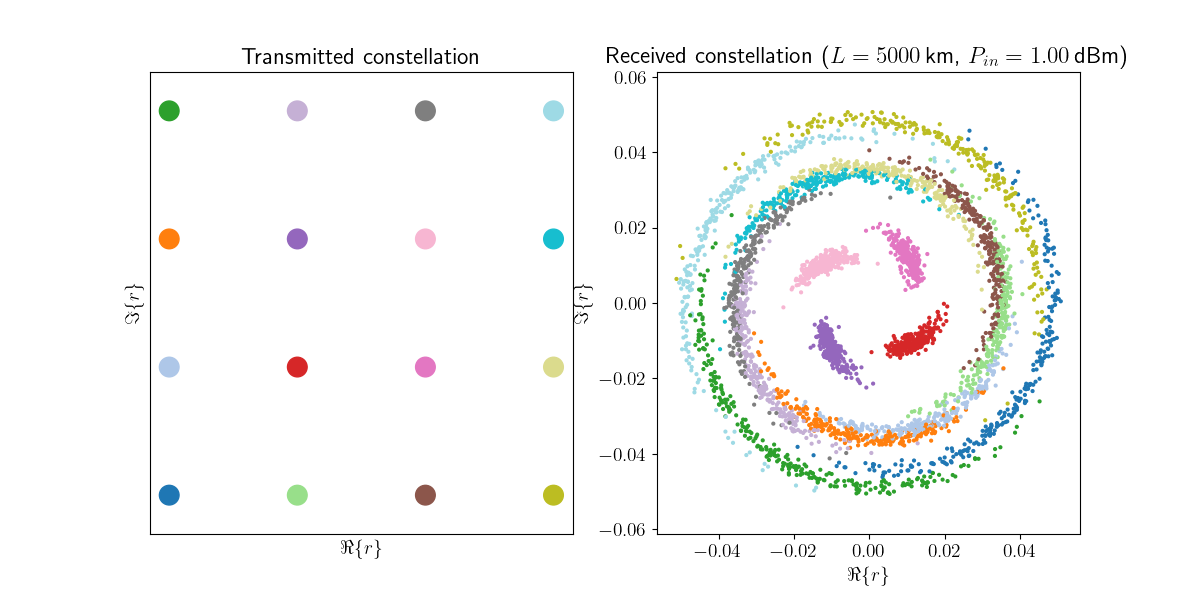

In [15]:
length_plot = 4000

def plot_constellation(Pin, constellation_name):
    constellation = constellations[constellation_name]
        
    t = np.random.randint(len(constellation),size=length_plot)
    r = simulate_channel(t, Pin, constellation)

    plt.figure(figsize=(12,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=True)
    plt.subplot(1,2,1)
    r_tx = constellation[range(len(constellation))]
    plt.scatter(np.real(r_tx), np.imag(r_tx), c=range(len(constellation)), marker='o', s=200, cmap='tab20')
    plt.xticks(())
    plt.yticks(())
    plt.axis('equal')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.title('Transmitted constellation')
    
    plt.subplot(1,2,2)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='tab20',s=4)
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title(r'Received constellation ($L = %d$\,km, $P_{in} = %1.2f$\,dBm)' % (L, Pin))    
    #plt.savefig('%s_received_zd_%1.2f.pdf' % (constellation_name.replace('-','_'),Pin),bbox_inches='tight')
    
interactive_update = interactive(plot_constellation, \
                                 Pin = widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=1, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')), \
                                 constellation_name = widgets.RadioButtons(options=['16-QAM','16-APSK'], value='16-QAM',continuous_update=False,description='Constellation'))


output = interactive_update.children[-1]
output.layout.height = '600px'
interactive_update

Text(0.5, 1.0, '$p(r)$ using GMM')

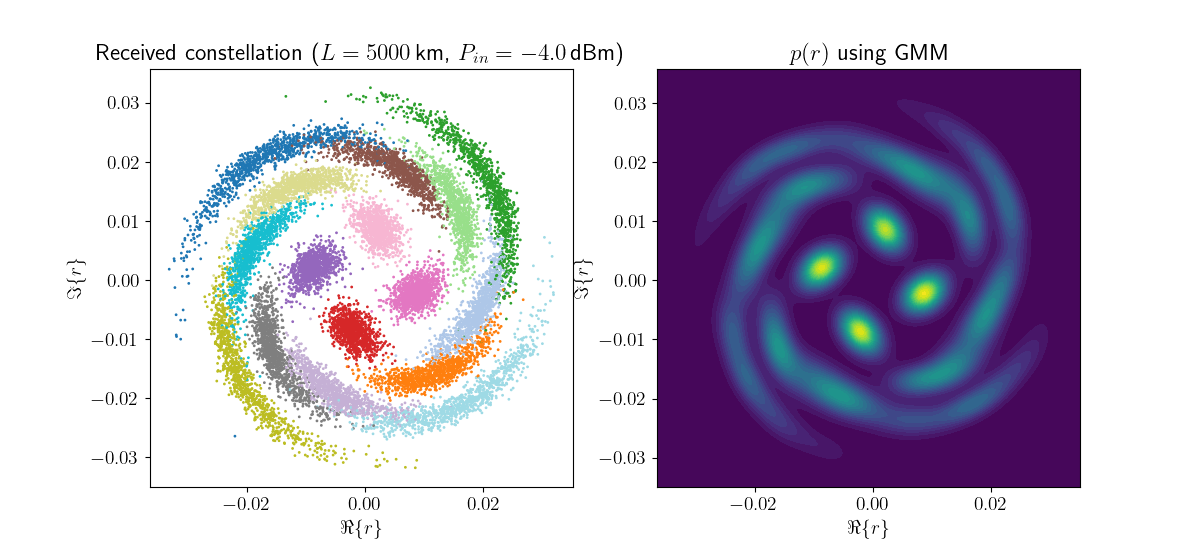

In [17]:
constellation = constellations['16-QAM']

# here, use 8*16 = 128 classes per points
m = 8*len(constellation)

Pin = -4
length_train = 16000

t = np.random.randint(len(constellation),size=length_train)
r = simulate_channel(t, Pin, constellation)

# generate training set
X_train = np.column_stack( (np.real(r), np.imag(r)) )
    

    # use sklearn toolbox to compute the GMMs
clf = mixture.GaussianMixture(n_components=m, covariance_type='full')
clf.fit(X_train)


# plot
# display predicted scores by the model as a contour plot
x = np.linspace(1.1*min(np.real(r)), 1.1*max(np.real(r)), 200)
y = np.linspace(1.1*min(np.imag(r)), 1.1*max(np.imag(r)), 200)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.exp(clf.score_samples(XX))
Z = Z.reshape(X.shape)

plt.figure(figsize=(12,5.5))
plt.subplot(121)
plt.scatter(np.real(r), np.imag(r), c=t, cmap='tab20',s=1)
plt.xlim((x[0], x[-1]))
plt.ylim((y[0], y[-1]))
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.title(r'Received constellation ($L = %d$\,km, $P_{in} = %1.1f$\,dBm)' % (L,Pin))

plt.subplot(122)
CS = plt.contourf(X, Y, Z, levels=30, cmap='viridis')
#for c in CS.collections:
#    c.set_edgecolor("face")
#    c.set_linewidth(0.000000000001)
    
plt.xlim((x[0], x[-1]))
plt.ylim((y[0], y[-1]))
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.title('$p(r)$ using GMM')
#plt.savefig('16_QAM_received_GMM.pdf',bbox_inches='tight')

Now we train a GMM for each constellation point individually. We will use this one to compute the mutual information (and hence the performance of a transmission scheme) later

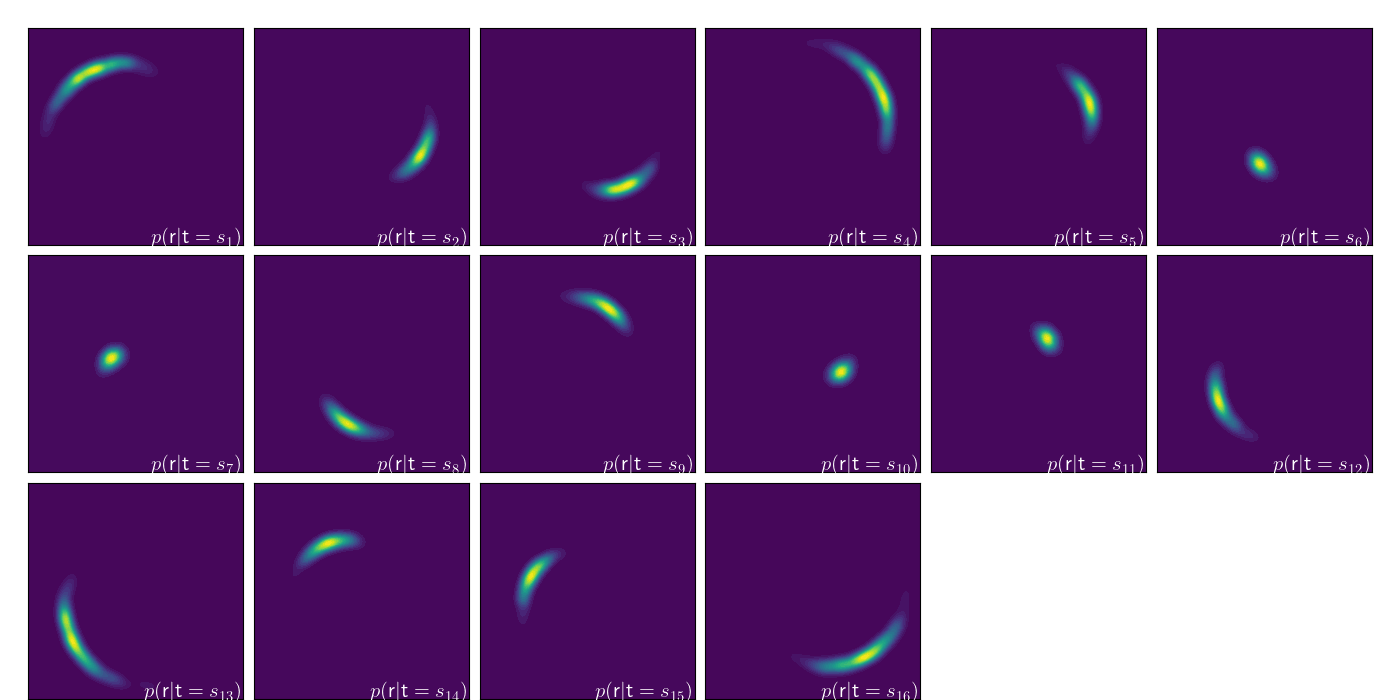

In [18]:
def train_GMMs(t,r,m, constellation):
    symbols = range(len(constellation))
    retval = [mixture.GaussianMixture(n_components=m, covariance_type='full') for k in symbols]
    for k in symbols:
        idx = t == k
        X_train = np.column_stack( (np.real(r[idx]), np.imag(r[idx])) )
        retval[k].fit(X_train)
    return retval

symbol_gmms= train_GMMs(t,r,10, constellations['16-QAM'])
plt.figure(figsize=(14,7))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.05)
for k in range(len(constellation)):
    Z = np.exp(symbol_gmms[k].score_samples(XX))
    Z = Z.reshape(X.shape)
    plt.subplot(3,6,k+1)
    CS = plt.contourf(X, Y, Z, levels=30, cmap='viridis')
    #for c in CS.collections:
    #    c.set_edgecolor("face")
    #    c.set_linewidth(0.000000000001)
    plt.xlim((x[0], x[-1]))
    plt.ylim((y[0], y[-1]))
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, '$p(\\textsf{r}|\\textsf{t}=s_{%d})$' % (k+1), transform=plt.gca().transAxes, size=15, horizontalalignment='right', color='w')
#plt.savefig('16_QAM_conditional_PDF_GMM_m10.pdf' ,bbox_inches='tight')    